# Drug Review Sentiment — Updated Pipeline
Centralized outputs in `results/` and parameterized training via `src/train_model.py`.


In [ ]:
# Optional: Colab setup — uncomment if running in Colab
# %pip install -U transformers datasets peft scikit-learn mlflow accelerate evaluate matplotlib seaborn kagglehub

import os, sys, pathlib, mlflow
import tensorboard
# Auto-detect repo root: if launched from notebooks/, go one level up
cwd = pathlib.Path().resolve()
repo_root = cwd.parent if cwd.name == 'notebooks' else cwd
os.chdir(repo_root)
sys.path.insert(0, str(repo_root))
print('CWD:', os.getcwd())

os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Ensure MLflow writes under results/mlruns regardless of where this notebook lives
mlruns_path = os.path.abspath(os.path.join('results', 'mlruns'))
os.makedirs(mlruns_path, exist_ok=True)
mlflow_uri = f'file://{mlruns_path}'
os.environ['MLFLOW_TRACKING_URI'] = mlflow_uri
mlflow.set_tracking_uri(mlflow_uri)
print('MLflow tracking URI:', mlflow.get_tracking_uri())


CWD: /home/sandra/drug-review-sentiment


In [5]:
# 1. Mount Google Drive (for saving models/results)
#from google.colab import drive
#drive.mount('/content/drive')

# 2. Clone your GitHub repo
#git clone https://github.com/sandragodinhosilva/drug-review-sentiment
#%cd drug-review-sentiment

# 3. Install dependencies
# !pip install -r requirements.txt

# 4. Tensorboard
%load_ext tensorboard
# %tensorboard --logdir /content/drive/MyDrive/biobert_project/biobert_logs

# 5. Verify GPU availability
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
# print("Current device:", torch.cuda.current_device())
# print("Tensor test:", torch.rand(3,3).cuda())


# 5. 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
CUDA available: False
Device: CPU


In [ ]:
# Parameters
model = 'distilbert-base-uncased'  # or 'dmis-lab/biobert-base-cased-v1.1'
subset_frac = 0.005  # use 0.0/None for full data
epochs = 1
batch_size = 16
fp16 = True  # set False on CPU


In [ ]:
# Preflight: check data files exist and have expected columns
import os, pandas as pd
train_path='data/drugsComTrain_raw.tsv'
test_path='data/drugsComTest_raw.tsv'
ok=True
for pth in [train_path, test_path]:
    if not os.path.exists(pth):
        print(f'MISSING: {pth}. Place the TSV in data/.')
        ok=False
    else:
        sz=os.path.getsize(pth)
        print(f'FOUND: {pth} ({sz/1e6:.1f} MB)')
        try:
            df=pd.read_csv(pth, sep='\t', nrows=5)
            print('Columns:', list(df.columns))
            need={'review','rating'}
            missing=need-set(df.columns)
            if missing:
                print(f'WARNING: missing expected columns: {missing}')
        except Exception as e:
            print(f'Could not read sample from {pth}:', e)
print('Preflight OK' if ok else 'Preflight FAILED')


2025-09-14 17:27:34 - my_app - INFO - Datasets loaded successfully.


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/12 [00:00<?, ? examples/s]

Map:   0%|          | 0/49 [00:00<?, ? examples/s]

2025-09-14 17:27:35 - my_app - INFO - Datasets tokenized.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
2025-09-14 17:27:35 - my_app - INFO - Selected LoRA target modules: ['k_lin', 'q_lin', 'v_lin']
2025-09-14 17:27:35 - my_app - INFO - Using weighted loss with class_weights: [1.7857142686843872, 0.6944444179534912]
2025-09-14 17:27:35 - my_app - INFO - Starting tainning.
/home/sandra/drug-review-sentiment/src/train_model.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


trainable params: 813,314 || all params: 67,768,324 || trainable%: 1.2001


/home/sandra/drug-review-sentiment/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss


/home/sandra/drug-review-sentiment/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/home/sandra/drug-review-sentiment/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
2025-09-14 17:27:57 - my_app - INFO - Done. Adapters at: results/outputs/distilbert-base-uncased-lora-128-weighted_loss-adapters


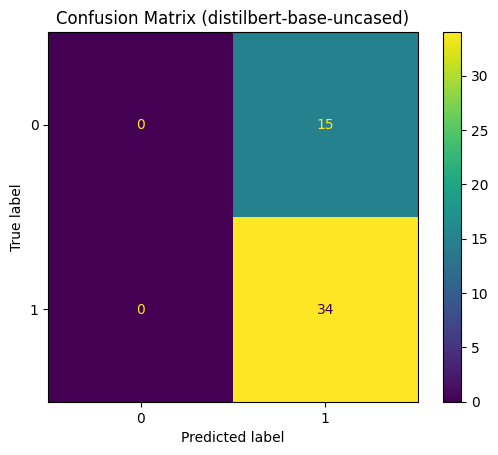

In [ ]:
# Run training via Python API
from src.train_model import train_model
train_model(
    model_name=model,
    batch_size=batch_size,
    num_train_epochs=epochs,
    imbalance_strategy='weighted_loss',
    fp16=fp16,
    subset_frac=subset_frac,
    use_tensorboard=True,
)


Last 20 log lines:
--- results/train_model.log (tail) ---


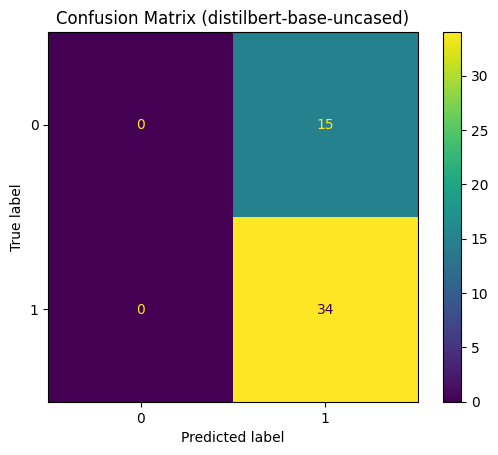

Test metrics: {}


In [6]:
# Inspect outputs in results/
import glob, os, json
from IPython.display import Image, display

# Show tail of log (pure Python for reliable output)
print('Last 20 log lines:')
try:
    with open('results/train_model.log', 'r') as fh:
        lines = fh.read().splitlines()
        if not lines:
            print('Log is empty.')
        else:
            print('--- results/train_model.log (tail) ---')
            for line in lines[-20:]:
                print(line)
except FileNotFoundError:
    print('No log yet: results/train_model.log not found.')
except Exception as e:
    print('Error reading log:', e)

# Show latest confusion matrix
cm_paths = sorted(glob.glob('results/outputs/*/cm.png'))
if cm_paths:
    display(Image(cm_paths[-1]))
else:
    print('No confusion matrix found yet.')

# Read MLflow test metrics from results/mlruns (pick latest run that has test_* metrics)
run_dirs = sorted(glob.glob('results/mlruns/*/*'))
metrics = {}
sel_run = None
for rd in reversed(run_dirs):
    if glob.glob(f'{rd}/metrics/test_*'):
        sel_run = rd
        break
if sel_run:
    for f in glob.glob(f'{sel_run}/metrics/test_*'):
        with open(f) as fh:
            t, v, step = fh.read().strip().split()
            metrics[os.path.basename(f)] = float(v)
    print('Run:', os.path.basename(sel_run))
    print('Test metrics:', json.dumps(metrics, indent=2))
else:
    print('No MLflow run with test metrics found yet.')
